# Self-Driving Car Engineer 
## Lucas Gago

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

### Import all required libraries

In [ ]:
# Libraries:
import os
import cv2
import pickle
import math
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from sklearn.cross_validation import train_test_split
%matplotlib inline

### Download the training and testing dataset if you don't have them

In [2]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

Training and Test data downloaded.


### Load and save the picked data

In [3]:
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
train_features, train_labels = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



In [4]:
n_train = len(train_features)
n_test = len(X_test)
image_shape = X_test[0].shape
n_classes = len(set(train_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Pandas DataFrame Generation

Using pandas, we can get the occurrence of each element in both the training and test sets

In [5]:
data_test = [[i,sum(y_test == i)] for i in range(len(np.unique(y_test)))]
data_test_sorted = sorted(data_test, key=lambda x: x[1])
data_train = [[i,sum(train_labels == i)] for i in range(len(np.unique(train_labels)))]
data_train_sorted = sorted(data_train, key=lambda x: x[1])
data_pd = pd.read_csv('signnames.csv')
data_pd['Occurrence (Train)'] = pd.Series(np.asarray(data_train_sorted).T[1], index=np.asarray(data_train_sorted).T[0])
data_pd['Occurrence (Test)'] = pd.Series(np.asarray(data_test_sorted).T[1], index=np.asarray(data_test_sorted).T[0])

data_pd_sorted = data_pd.sort_values(['Occurrence (Train)'],ascending=[0]).reset_index()
data_pd_sorted = data_pd_sorted.drop('index', 1)

### Head and tail of the DataFrame

In [6]:
data_pd_sorted.head()

,ClassId,SignName,Occurrence (Train),Occurrence (Test)
0,2,Speed limit (50km/h),2250,750
1,1,Speed limit (30km/h),2220,720
2,13,Yield,2160,720
3,12,Priority road,2100,690
4,38,Keep right,2070,690


In [7]:
data_pd_sorted.tail()

,ClassId,SignName,Occurrence (Train),Occurrence (Test)
38,32,End of all speed and passing limits,240,60
39,27,Pedestrians,240,60
40,37,Go straight or left,210,60
41,19,Dangerous curve to the left,210,60
42,0,Speed limit (20km/h),210,60


### Visualization of the dataset

The function `Generate_Example` picks one random picture from the dataset per class, and their are saved into `features_example`, for later comparison in performance

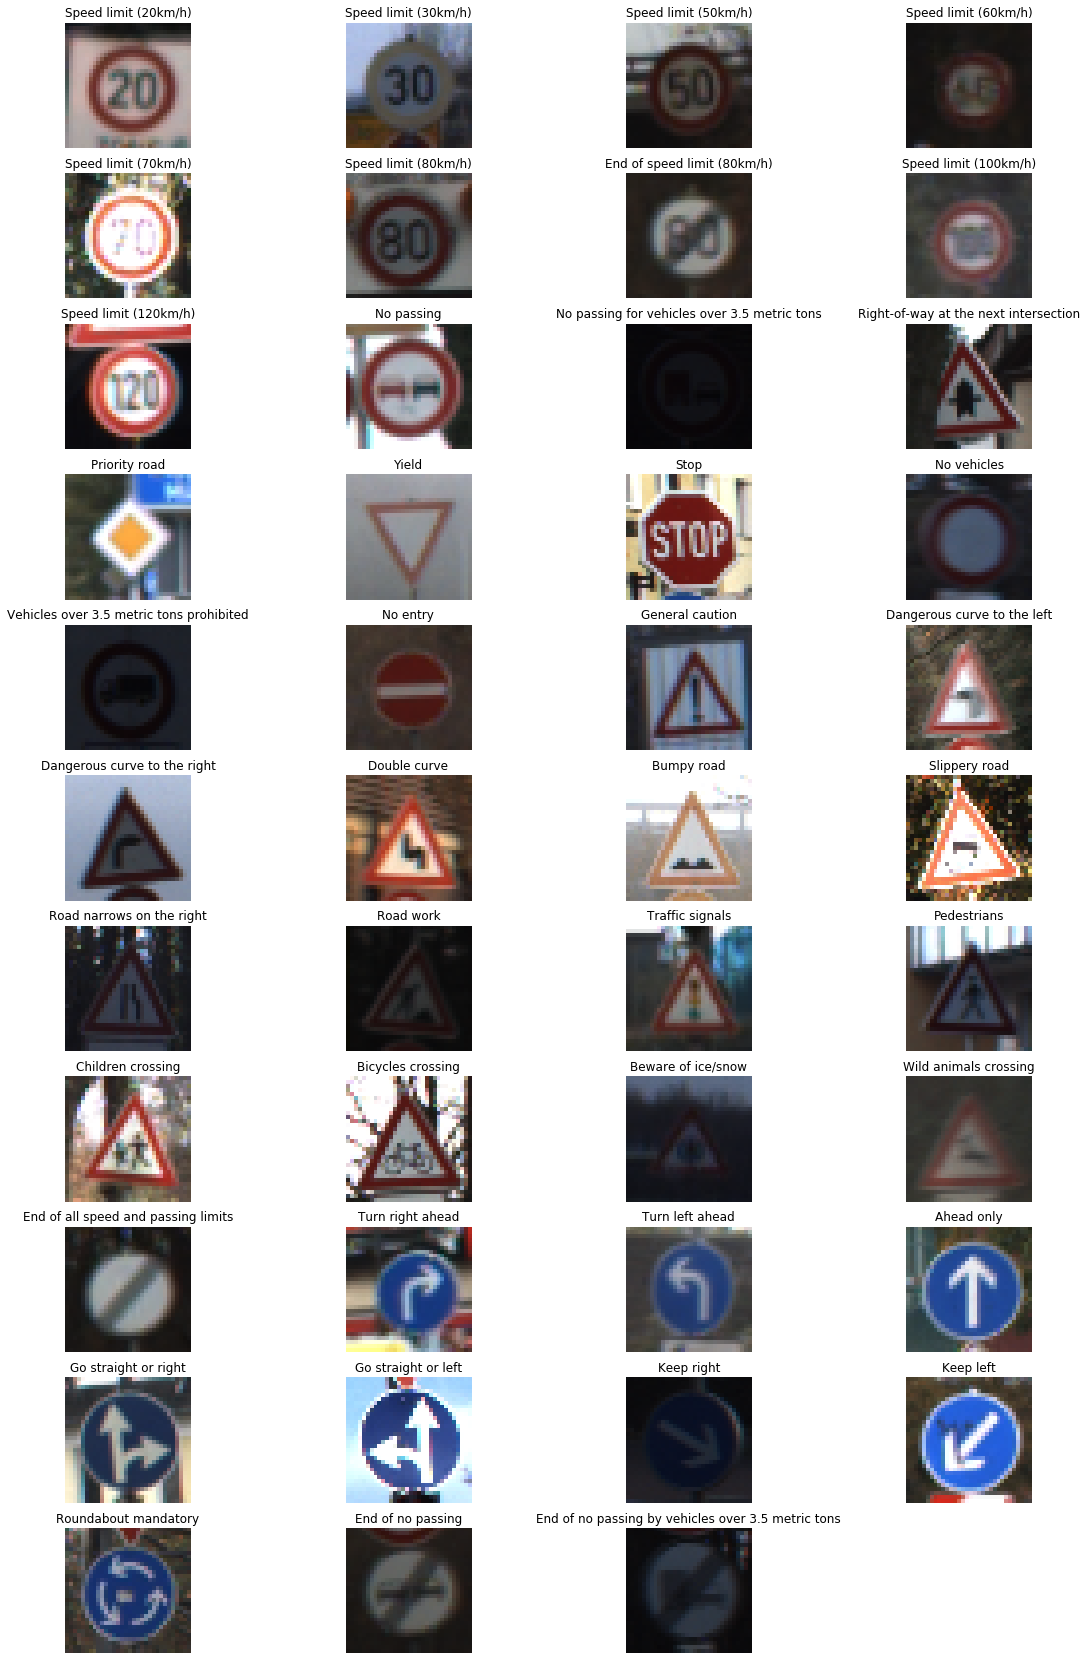

In [8]:
def Generate_Example(h,w,X,Y):
    features_example=[]
    plt.figure(figsize = (20,30))
    gs1 = gridspec.GridSpec(h,w)
    gs1.update(wspace=0.02, hspace=0.2) # set the spacing between axes. 
    for i in range(n_classes):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        current=np.where(Y==i)[0]
        ind = np.random.randint(0,len(current))
        plt.imshow(X[current[ind]])
        sign_number=(Y[current[ind]])
        plt.title(data_pd.iloc[sign_number].SignName)
        plt.axis('off')
        features_example.append(X[current[ind]])
    plt.show()
    return features_example

features_example=Generate_Example(11,4,train_features,train_labels)

The funcion `showGrid` is used to have a random look into the dataset

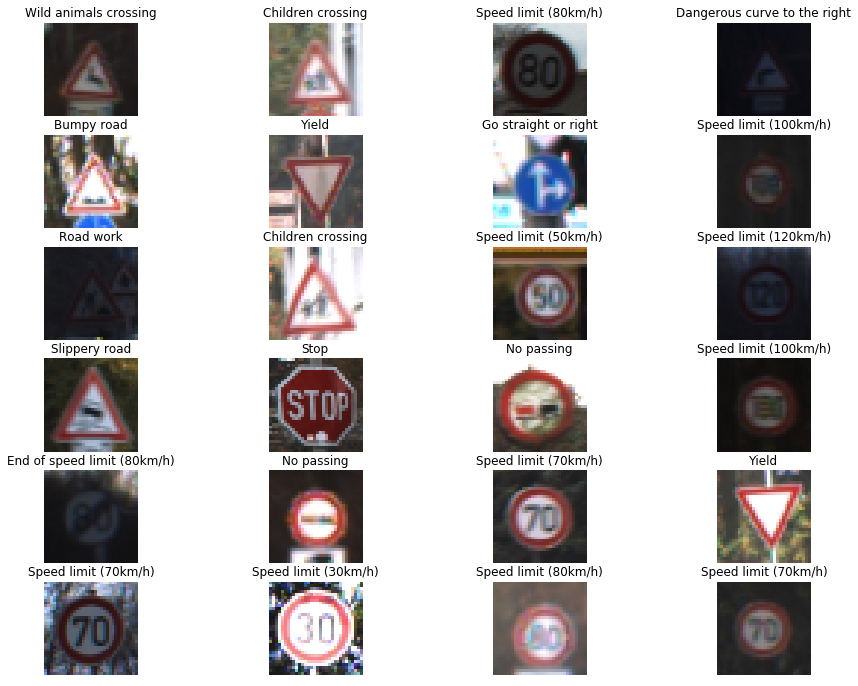

In [9]:
def showGrid(h,w,X,Y):
    plt.figure(figsize = (16,12))
    gs1 = gridspec.GridSpec(h,w)
    gs1.update(wspace=0.02, hspace=0.2) # set the spacing between axes. 
    for i in range(h*w):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        ind_plot = np.random.randint(1,len(Y))
        plt.imshow(X[ind_plot])
        sign_number=(Y[ind_plot])
        plt.title(data_pd.iloc[sign_number].SignName)
        plt.axis('off')
    plt.show()
    

showGrid(6,4,train_features,train_labels)

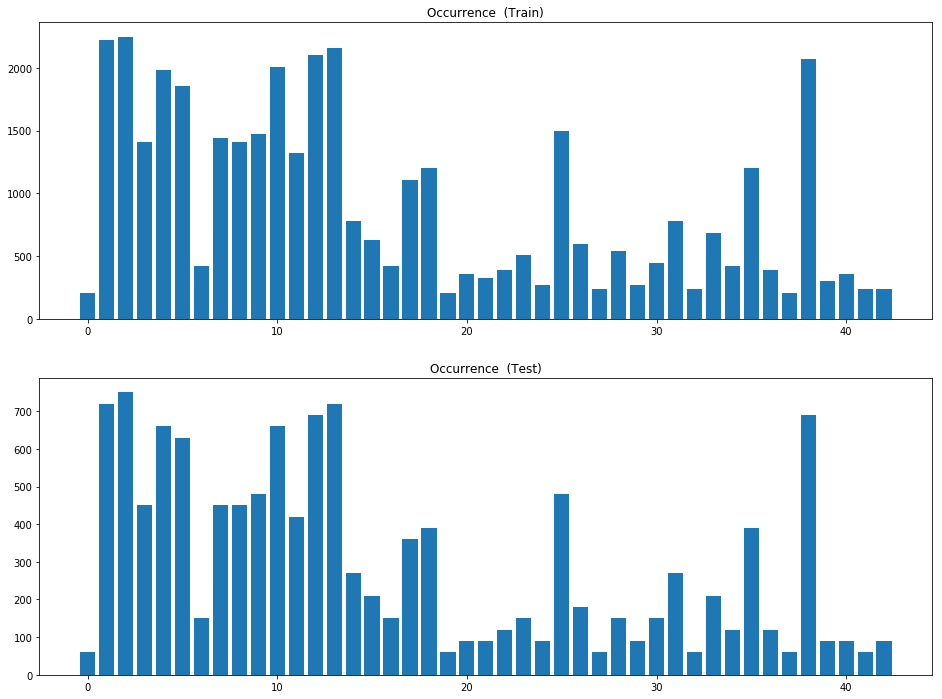

In [10]:
plt.figure(figsize=(16,12))
plt.subplot(212)
plt.bar(range(43),height=data_pd["Occurrence (Test)"])
plt.title("Occurrence  (Test)")

plt.subplot(211)
plt.bar(range(43),height=data_pd["Occurrence (Train)"])
plt.title("Occurrence  (Train)")
plt.show()

Ploting this bar graphs, we can see that the uneven distribution of data in clases is almost the same in both training and test, so data augmentation have to be uniform

----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. Trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 


### Pre-process the Data Set 

After trying different combinations, such as histogram equalization, random rotations, noise and blur, the most simple one gives the best performance.

The final model only uses the original pictures plus random bright and blur. This generates tree times more data and improves performance by 5%

In [11]:
%%time

#Random bright

new=[]
new_blur=[]
for feature in train_features:
    #feature = cv2.cvtColor(feature, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    #feature[:,:,0] = cv2.equalizeHist(feature[:,:,0])
    # convert the YUV image back to RGB format
    #feature = cv2.cvtColor(feature, cv2.COLOR_YUV2BGR)
    rnd_number=np.random.uniform()
    image1 = cv2.cvtColor(feature,cv2.COLOR_BGR2HSV)
    random_bright = .25+rnd_number
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2BGR)
    kernel = np.ones((3,3),np.float32)/9
    image1 = cv2.filter2D(image1,-1,kernel)
    new.append(image1)
    
#Blur
    
for feature in train_features:
    #feature = cv2.cvtColor(feature, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    #feature[:,:,0] = cv2.equalizeHist(feature[:,:,0])
    # convert the YUV image back to RGB format
    #feature = cv2.cvtColor(feature, cv2.COLOR_YUV2BGR)
    kernel = np.ones((3,3),np.float32)/9
    image1 = cv2.filter2D(feature,-1,kernel)
    new_blur.append(image1)
train_features_arg=np.concatenate((train_features,new,new_blur),axis=0)
print(len(train_labels))
train_labels_arg=np.concatenate((train_labels,train_labels,train_labels),axis=0)
print(len(train_labels_arg))


39209
117627
CPU times: user 5.13 s, sys: 280 ms, total: 5.41 s
Wall time: 5.41 s


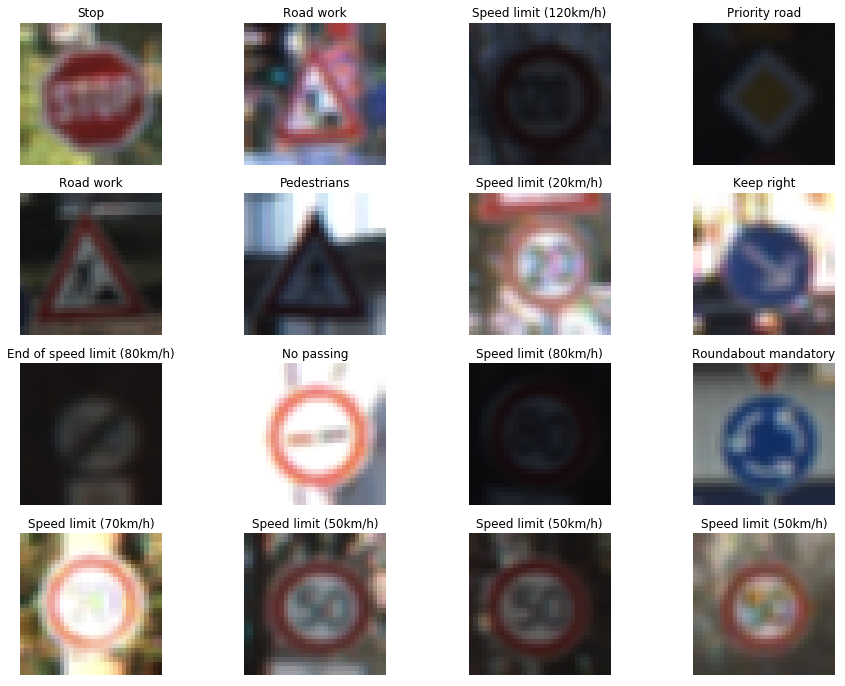

In [12]:
showGrid(4,4,new_blur,train_labels)

In [13]:
X_train=train_features_arg
y_train=train_labels_arg

Normalization between -1 and 1:

In [14]:
# Normalize between -1 and 1
X_train=np.array(X_train)
X_train = X_train.astype('float32')
X_train = (X_train - 128.) / 128.
X_test = X_test.astype('float32')
X_test  = (X_test  - 128.) / 128.

Data shuffle and validation generation:

In [15]:
X_train, y_train = shuffle(X_train, y_train)
print("Data shuffled")
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.15)
print("Validation ready")

Data shuffled
Validation ready


### Model Architecture

Hiperparameters for easy tunning. Beta is for L2 regularization.

In [25]:
EPOCHS = 100
BATCH_SIZE = 500
LEARNING_RATE= .0001
BETA=5e-5
DROPOUT_KEEP=.5

### Train, Validate and Test the Model

I'm going to implement LeNet, a pioneering  convolutional network by Yann LeCun, moddified to classify color images. Also added dropout and l2 regularization to avoid overfitting

<img src="lenet_architecture-768x226.png">

In [17]:
def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # L2 Regularization
    l2_loss= (tf.nn.l2_loss(conv1_W)+tf.nn.l2_loss(conv2_W)+tf.nn.l2_loss(fc2_W)+tf.nn.l2_loss(fc1_W)+tf.nn.l2_loss(fc3_W))
    
    return logits,l2_loss

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [19]:
logits,l2 = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+BETA*l2
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
%%time
# Add session close after reading previous high score
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    saver.restore(sess, save_path='savedata/lenetTop')
    top_accuracy = evaluate(X_test, y_test)
    print("The previous best score was: {:.4f}".format(top_accuracy))
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:DROPOUT_KEEP})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        if (i+1)%10==0:
            test_accuracy = evaluate(X_test, y_test)
                
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.4f}".format(validation_accuracy))
            print("Test Accuracy = {:.4f}".format(test_accuracy))
            if (i+1)%50==0:
                saver.save(sess, 'savedata/lenet2')
                print(" ######## Model saved ######## ")
                print()
            
            if test_accuracy>top_accuracy:
                saver.save(sess, 'savedata/lenetTop')
                top_accuracy=test_accuracy
                print("#############################")
                print()
                print("New best! Now is: {:.4f}".format(top_accuracy))
                print()
                print("#############################")
                print()


    saver.save(sess, 'savedata/lenet2')
    print("Model saved")

Training...

The previous best score was: 0.9713

EPOCH 10 ...
Validation Accuracy = 0.9956
Test Accuracy = 0.9710
EPOCH 20 ...
Validation Accuracy = 0.9955
Test Accuracy = 0.9705
EPOCH 30 ...
Validation Accuracy = 0.9956
Test Accuracy = 0.9699
EPOCH 40 ...
Validation Accuracy = 0.9955
Test Accuracy = 0.9705
EPOCH 50 ...
Validation Accuracy = 0.9955
Test Accuracy = 0.9699
 ######## Model saved ######## 

EPOCH 60 ...
Validation Accuracy = 0.9955
Test Accuracy = 0.9702
EPOCH 70 ...
Validation Accuracy = 0.9956
Test Accuracy = 0.9694
EPOCH 80 ...
Validation Accuracy = 0.9955
Test Accuracy = 0.9700
EPOCH 90 ...
Validation Accuracy = 0.9954
Test Accuracy = 0.9707
EPOCH 100 ...
Validation Accuracy = 0.9954
Test Accuracy = 0.9691
 ######## Model saved ######## 

Model saved
CPU times: user 7min 25s, sys: 2min 17s, total: 9min 42s
Wall time: 10min 20s


In [24]:
with tf.Session() as sess:
    saver.restore(sess, save_path='savedata/lenetTop')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.4f}".format(test_accuracy))

Test Accuracy = 0.9713


### Model Results

After training for over 2 hours into a g2.2large instance from AWS and finetunning, the model achieves over 99.6% on validation and 97.1% on test. Human performance is about 98%, and probably using a bigger network and more training could improve results.

---

## Step 3: Model  Test on New Images



### Load and Output the Images

In [32]:
def read_image(directoy):
    image = cv2.imread(directoy)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def process_image(image):
    image = cv2.resize(image,(32,32))
    image=np.array(image)
    image = image.astype('float32')
    image = (image-128.)/128.
    return image


def showGrid_new_images(h,w,X,Y):
    plt.figure(figsize = (12,8))
    gs1 = gridspec.GridSpec(h,w)
    gs1.update(wspace=0.02, hspace=0.2)
    for i in range(h*w):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.imshow(X[i])
        plt.title(Y[i].split('.')[0])
        plt.axis('off')
    plt.show()



Read and show new images from the internet

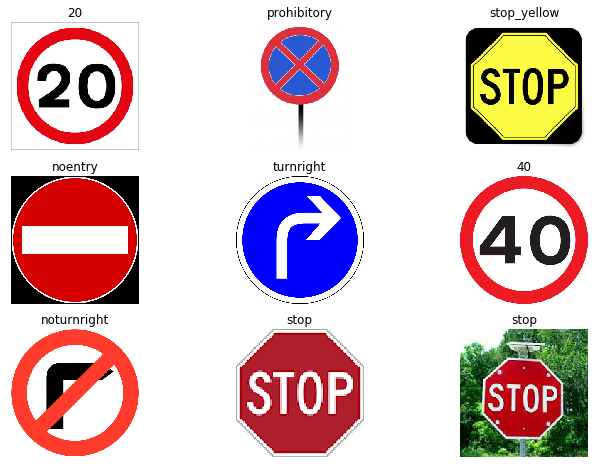

In [37]:
names = [name for name in os.listdir("./images/")]
newdata = [read_image("./images/"+name) for name in names]
newdata_processed=[process_image(img) for img in newdata]
newdata_processed = np.array(newdata_processed ,dtype = np.float32)

showGrid_new_images(3,3,newdata,names)

### Predict the Sign Type for Each Image

In [38]:
labels_pred = tf.nn.softmax(logits)
feed_dict_new = {x:newdata_processed,keep_prob: 1}
top5 = tf.nn.top_k(labels_pred, 5)
with tf.Session() as sess:
    saver.restore(sess, save_path='savedata/lenetTop')
    predictions = sess.run(top5,feed_dict = feed_dict_new)
    top5_pred = sess.run([labels_pred, top5], feed_dict=feed_dict_new)

### Analyze Performance, Top 5 Softmax Probabilities For Each Image Found on the Web

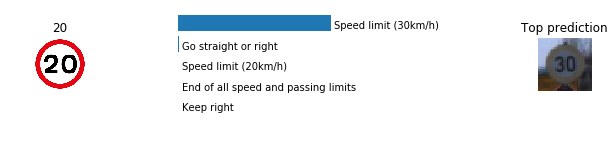

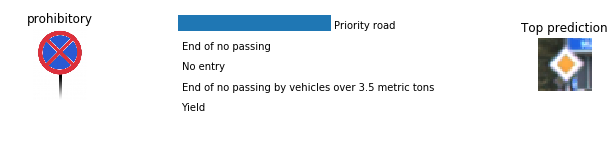

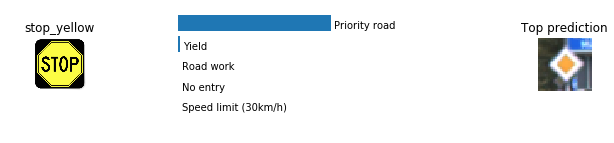

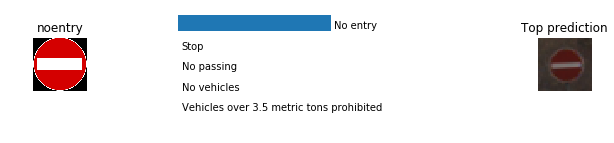

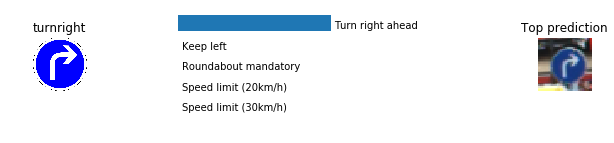

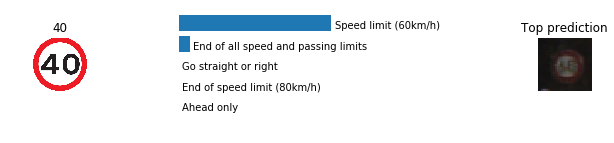

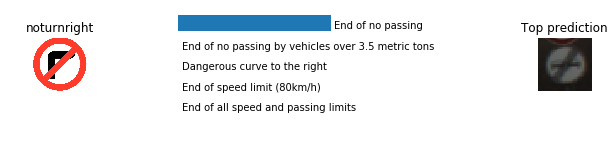

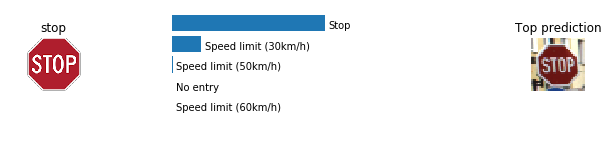

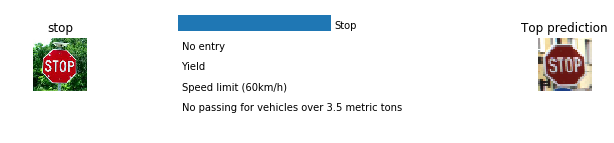

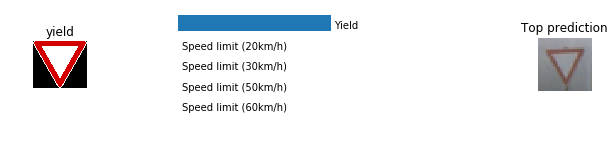

In [39]:
for i in range(len(newdata_processed)):
    plt.figure(figsize = (10,2))
    gs = gridspec.GridSpec(1, 5,width_ratios=[2,2,6,6,2])
    plt.subplot(gs[0])
    plt.imshow(newdata[i])
    plt.title(names[i].split('.')[0])
    plt.axis('off')
    plt.subplot(gs[2])
    plt.barh(6-np.arange(5),top5_pred[1][0][i], align='center')
    for i_label in range(5):
        plt.text(top5_pred[1][0][i][i_label]+.02,6-i_label-.25,data_pd['SignName'][top5_pred[1][1][i][i_label]])
    plt.axis('off')
    plt.subplot(gs[4])
    plt.imshow(features_example[top5_pred[1][1][i][0]])
    plt.title("Top prediction")
    plt.axis('off')
    plt.show()

### Training over new data

As we can see, performance is great. Predicting 6 existing images in the dataset (20,2 stops, yield, turn right and no entry) only fails in the 20, but it's into the first five. The yellow stop is labeled as a yellow priority road (as expected, the only yellow class). 40 is not into the dataset, but the model labels it as 60. No turn right (not into the dataset) is predicted to be end of no passing, pretty similar. It gives a performance of 90% over the new images (counting as right the new ones due to similarity).The model is very confident in it's own predictions.